In [29]:
#!pip install -U langgraph langchain_openai langchain_community python-dotenv
import os
from typing import TypedDict, List, Literal,Annotated, Optional
from pydantic import BaseModel, Field
from langgraph.graph import StateGraph, END
from langchain_core.messages import HumanMessage, AIMessage
from langchain_openai import ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate
import time


class ClassificationResult(BaseModel):
    """Classification result for user queries"""
    category: Literal["faq","api","human"]

class ClarificationRequest(BaseModel):
    """Structure for required clarification details"""
    need_info: bool
    missing_info: List[str] = Field(..., description="Specific information needed to resolve the issue")
    example_format: Optional[str] = Field(None, description="Example of what information to provide")

class AgentState(TypedDict):
    conversation_history: Annotated[List[HumanMessage | AIMessage], lambda x, y: x + [y]]
    current_query: str
    needs_human: bool
    unresolved_issues: List[str]
    retry_count: int
    pending_clarification: Optional[ClarificationRequest] 

primary_llm = ChatOpenAI(model="gpt-4o-mini")
validation_llm = ChatOpenAI(model="gpt-4o")

def classify_query(state: AgentState):
    prompt = ChatPromptTemplate.from_template("""
    Classify this user query into exactly one category:
    - faq: General questions about pricing, documentation, or features
    - api: Technical issues with API endpoints, errors, or integration
    - human: Emotional requests, complaints, or complex account issues
 
    User Query: {current_query}
    """)
    structured_llm = primary_llm.with_structured_output(ClassificationResult)
    chain = prompt | structured_llm
    
    result = chain.invoke({"current_query": state["current_query"]})
    print(f"Category: {result.category}")
    return {"category": result.category,"conversation_history": [HumanMessage(content=state["current_query"])]}

def handle_faq(state: AgentState):
    prompt = ChatPromptTemplate.from_messages([
        ("system", """You're a helpful customer support bot. Answer this FAQ.
        Known FAQs:
        - Pricing: $99/month
        - API docs: https://api.example.com
        - Support hours: 24/7"""),
        ("user", "{current_query}")
    ])
    
    chain = prompt | primary_llm
    response = chain.invoke({"current_query": state["current_query"]})

    return {
        "current_query": "",
        "conversation_history":[AIMessage(content=response.content)]
    }

async def perform_initial_diagnosis(state: AgentState):
    prompt = ChatPromptTemplate.from_messages([
        ("system", """Analyze API issue and either:
        1. Resolve with solution
        2. Request specific missing info using Clarification Request schema
        
        """),
        ("user", "{current_query}")
    ])
    
    structured_llm = primary_llm.with_structured_output(ClarificationRequest)
    chain = prompt | structured_llm
    
    try:
        clarification_needs = await chain.ainvoke({
            "current_query": state["current_query"],
        })

        if clarification_needs.need_info:
            return {
                "pending_clarification": clarification_needs,
                "conversation_history": [AIMessage(content=format_clarification_request(clarification_needs))]
            }
        else:
            return {
                "pending_clarification": None,
            }

    
    except Exception as e:
        return {"unresolved_issues": ["API System Down"], "current_query": ""}
    

def format_clarification_request(request: ClarificationRequest) -> str:
    message = "To help resolve your API issue, please provide:"
    message += "\n- " + "\n- ".join(request.missing_info)
    if request.example_format:
        message += f"\n\nExample format:\n{request.example_format}"
    return message

async def create_support_ticket(state: AgentState):

    ticket_id = f"TKT-{os.urandom(4).hex().upper()}"
    
    return {
        "conversation_history": [AIMessage(content=f"Ticket created: {ticket_id}")],
        "unresolved_issues": [],
        "current_query": ""
    }

def invoke_human_agent(state: AgentState):

    return {
        "needs_human": True,
        "conversation_history":[AIMessage(content="Transferring to human agent...")]
    }


def route_category(state):
    if state.get("category"):
        return state["category"]
    return "error"

async def handle_clarification(state: AgentState):
    state["current_query"] = input("Please provide additional details about your API issue:")
    print(f"""User: {state["current_query"]}""")

    prompt = ChatPromptTemplate.from_messages([
        ("system", """Process user's clarification response:
        {pending_clarification}
        
        History: {conversation_history}
        User's response: {current_query}""")
    ])
    
    chain = prompt | validation_llm.with_structured_output(ClarificationRequest)
    response = await chain.ainvoke(state)
    conversation_history = [HumanMessage(content=state["current_query"])]
    if response.need_info:
        conversation_history.append(AIMessage(content=format_clarification_request(response)))
    
    return {
        "retry_count": state.get("retry_count", 0) + 1,
        "pending_clarification": response.need_info,
        "conversation_history":conversation_history
    }


async def check_api_resolution(state):
    MAX_RETRIES = 2

    if state.get("retry_count", 0) > MAX_RETRIES:
        return "create_ticket"
    
    if state.get("pending_clarification", ""):
        return "need_clarification"
    
    return "create_ticket"

workflow = StateGraph(AgentState)

# Add nodes
workflow.add_node("classify_query", classify_query)
workflow.add_node("handle_faq", handle_faq)
workflow.add_node("initial_diagnosis", perform_initial_diagnosis)
workflow.add_node("create_ticket", create_support_ticket)
workflow.add_node("human_agent", invoke_human_agent)
workflow.add_node("need_clarification", handle_clarification)

# Set entry point
workflow.set_entry_point("classify_query")

# Add edges
workflow.add_edge("handle_faq", END)
workflow.add_edge("create_ticket", END)
workflow.add_edge("human_agent", END)
workflow.add_edge("initial_diagnosis", "need_clarification")

workflow.add_conditional_edges(
    "need_clarification",
    check_api_resolution,
    {
        "need_clarification": "need_clarification",
        "create_ticket":"create_ticket"
    }
)

workflow.add_conditional_edges(
    "classify_query",
    route_category,
    {
        "faq": "handle_faq",
        "api": "initial_diagnosis",
        "human": "human_agent"
    }
)


compiled_workflow = workflow.compile()



async def run_conversation(query):
    
    current_state = AgentState(
        conversation_history=[],
        current_query="",
        needs_human=False,
        unresolved_issues=[],
        retry_count=0,
        pending_clarification=None
    )
    
    print(f"\nUser: {query}")
    current_state["current_query"] = query
    
    async for step in compiled_workflow.astream(current_state,stream_mode="values"):
        if step["conversation_history"]:
            flatten_messages = [x for xs in step["conversation_history"] for x in xs]
            ai_messages = [msg for msg in flatten_messages if type(msg) is AIMessage]
            if ai_messages:

                last_msg = ai_messages[-1]
                print(f"Bot: {last_msg.content}")
                time.sleep(1)
                        

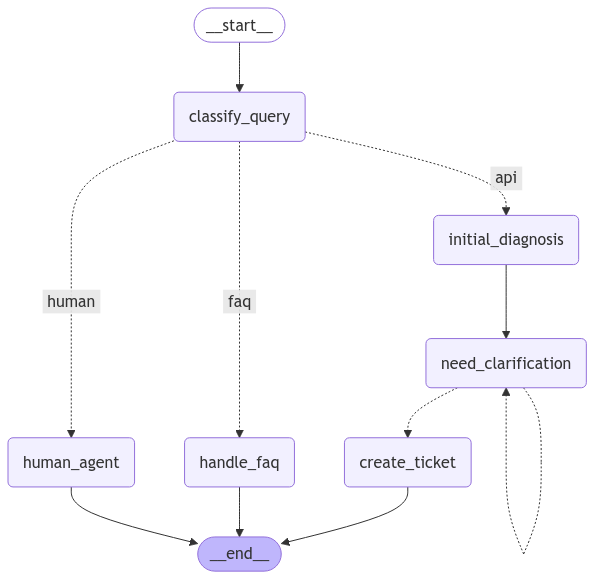

In [30]:
from IPython.display import Image, display
from langchain_core.runnables.graph import CurveStyle, MermaidDrawMethod, NodeStyles

display(
    Image(
        compiled_workflow.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)

In [31]:
await run_conversation("I´m getting api errors")
#Im getting a 503 acess denied at the v1/users/register post endpoint
#im using python requests library and it should register a payload with user and password and return an id
# Endpoint: '/v1/users/register', Method: 'POST', Payload: '{"user": "Mario", "password": "123456"}', Headers: '{"Content-Type": "application/json", "Authorization": "Bearer token"}'


User: I´m getting api errors
Category: api
Bot: To help resolve your API issue, please provide:
- What specific API errors are you encountering?
- What endpoint are you trying to access?
- What is the expected outcome versus the actual outcome?
- Can you provide any error messages or codes you are receiving?

Example format:
Error message: 404 Not Found, Endpoint: /api/v1/resources
User: Im getting a 503 acess denied at the v1/users/register post endpoint
Bot: To help resolve your API issue, please provide:
- What is the expected outcome versus the actual outcome?
- Can you provide any additional error messages or codes you are receiving?

Example format:
Error message: 503 Access Denied, Endpoint: /api/v1/users/register
User: im using python requests library and it should register a payload with user and password and return an id
Bot: To help resolve your API issue, please provide:
- What does your request payload look like?
- What headers are you sending in your request?
- Any addit

In [32]:
await run_conversation("How much is the monthly fee?")


User: How much is the monthly fee?
Category: faq
Bot: The monthly fee is $99.


In [4]:
await run_conversation("Can you please provide the documentation?")


User: Can you please provide the documentation?
Category: faq
Bot: Sure! You can find the API documentation at this link: [https://api.example.com](https://api.example.com). If you have any questions about the documentation, feel free to ask!


In [5]:
await run_conversation("What is the working hours for the tech support?")


User: What is the working hours for the tech support?
Category: faq
Bot: Our tech support is available 24/7, so you can reach out for assistance anytime you need help.
